## Mount Google Drive in Colab

In [0]:
from google.colab import drive
drive.mount('/content/drive')

## Perform imports

In [0]:
import numpy as np
from os import listdir

## Load image and label batches from file and create 2-D array containing image and label information.

In [0]:
# Google Drive folder where NumPy arrays are stored
path = '/content/drive/My Drive/Final Capstone/Images/'
count = 1
# looping through the 3 batches of images and labels
while (count < 4):
  # load image batch (X) and label batch (Y)
  X = np.load(path + 'X' + str(count) + '.npy')
  Y = np.load(path + 'Y' + str(count) + '.npy')
  # reshape image and label batch to 2-D
  X = np.reshape(X, (X.shape[0], -1), order='C')
  Y = np.reshape(Y, (Y.shape[0], 1))
  Y = Y.astype(X.dtype)

  # append label batch to image batch along the column axis and add new data along the row axis
  if (count == 1):
    Z = np.append(X, Y, axis=1)
  else:
    Z = np.append(Z, np.append(X, Y, axis=1), axis=0)

  del X
  del Y

  count += 1

## Shuffle data

At this point, the data is in the order that it was read from the folders in the previous notebook, meaning that one patient's images are together sequentially and that each patient's positive images and negative images are each together sequentially.  In order to avoid patient-based bias in creating a balanced dataset, the data are shuffled.

In [0]:
# shuffles data along row axis 10 times
for i in range(10):
  np.random.shuffle(Z)

## Count number of IDC-positive and IDC-negative images and determine the minimum of the two quantities

In [0]:
# indices of IDC-positive data
pos_indices = np.nonzero(Z[:, 7500] == 1)[0]
# indices of IDC-negative data
neg_indices = np.nonzero(Z[:, 7500] == 0)[0]
# minimum of two quantities
num_each = min(pos_indices.shape[0], neg_indices.shape[0])

## Select maximum number of IDC-positive and IDC-negative images to create balanced dataset

In [0]:
# positive image selected counter
count_pos = 0
# negative image selected counter
count_neg = 0
# Z index tracker
index = 0
# list used to track slices of Z to extract, tuples are saved for use with range function
use_index_list = []

# loop until maximum number of IDC-positive and IDC-negative images is reached
while (count_pos < num_each or count_neg < num_each):

  # batch size exponent allows variable size of batches to be used, speeds up process
  batch_size_exponent = 5
  # indicates whether the current batch size should be used to select a slice from Z
  use_batch_size = False
  
  # loop through batch size exponents until an appropriate batch size is selected
  while (batch_size_exponent >= 0):
    # calculate batch size
    batch_size = 2 ** batch_size_exponent

    # determine if batch size is greater than entries remaining in Z and reduces batch size to # of remaining entries if so, useful for last batch
    if (index + batch_size > Z.shape[0]):
      batch_size = Z.shape[0] - index

    # select slice of Z based on batch size and index
    current = Z[index:(index + batch_size), :]
    # count number of IDC-positive images in batch
    current_count_pos = np.nonzero(current[:, 7500] == 1)[0].shape[0]
    # count number of IDC-negative images in batch
    current_count_neg = np.nonzero(current[:, 7500] == 0)[0].shape[0]

    # determine whether batch size is acceptable
    if (count_pos + current_count_pos <= num_each and count_neg + current_count_neg <= num_each):
      # use batch size if the maximum number of either type of image is not exceeded by using currect batch size
      use_batch_size = True
      # break out of "while" loop for batch size
      break
    
    # decrease batch size if batch size is too big, only reached if batch size is too big due to "break" in previous "if" clause
    batch_size_exponent -= 1
  
  # save batches indices and updates counts and index for next loop
  if (use_batch_size):
    # save tuple of batch indices for use with range function
    use_index_list.append((index, index + batch_size))
    # update count of IDC-positive images
    count_pos += current_count_pos
    # update count of IDC-negative images
    count_neg += current_count_neg
    # update index to look just past batch just analyzed
    index += batch_size
    del current
  # if batch_size reaches 1 and is still not acceptable for use, the index is incremented by 1
  # this is necessary when one of the image types has reached its maximum count
  else:
    index += 1

In [0]:
# list to hold indices to select
index_select_list = []
# add each index to select to list
for tup in use_index_list:
  for i in range(tup):
    index_select_list.append(i)

In [0]:
# slice selected indices from Z
Z = Z[index_select_list, :]

## Shuffle data to ensure even distribution of IDC-positive and IDC-negative images in dataset

In [0]:
# shuffles data along row axis 10 times
for i in range(10):
  np.random.shuffle(Z)

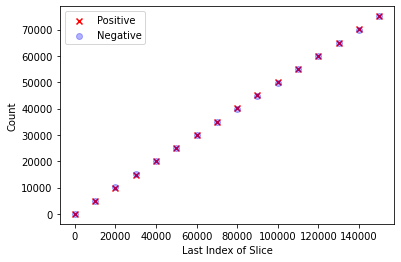

In [0]:
# generate plot showing balanced data with increasing index (i.e., there are no long sequences dominated by one class)
pos_count_list = []
neg_count_list = []
x_list = []
for i in range((Z.shape[0] // 10000) + 1):
  x_list.append(i * 10000)
  pos_count_list.append(np.nonzero(Z[:(i * 10000), 7500] == 1)[0].shape[0])
  neg_count_list.append(np.nonzero(Z[:(i * 10000), 7500] == 0)[0].shape[0])

import matplotlib.pyplot as plt

plt.scatter(x_list, pos_count_list, c='r', marker='x')
plt.scatter(x_list, neg_count_list, c='b', alpha=0.3)
plt.legend(['Positive', 'Negative']), plt.ylabel('Count'), plt.xlabel('Last Index of Slice')
plt.show()

## Save balanced data for use by models

In [0]:
np.save('/content/drive/My Drive/Final Capstone/Balanced Data', Z)